Trabalharemos aqui apenas com a base nomeada, realizando nossas avaliações por validação cruzada. E importamos todos os modelos e e bibliotecas utilizadas, além de configurações inicias.

In [779]:
import os
import datetime
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error,make_scorer


# Dribla warnings do sklearn:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

sns.set()  # seta gráficos nas configurações padrões do seaborn
random_state = 0  # para resultados serem reproduzíveis


# Salva o caminho do arquivo em uma variável para acesso mais fácil
caminho_arquivo_house = Path.cwd()

# Define o caminho relativo para a pasta de dados
pasta_dados = caminho_arquivo_house / "Dados" / "train.csv"

# Lê os dados de treinamento e armazena-os em um DataFrame chamado house_data_train
house_data_train = pd.read_csv(pasta_dados)

As métricas utilizadas para avaliação dos modelos serão a média dos erros absolutos (MAE) entre os valores observados e as predições, bem como o coeficiente de determinação (R²). Para fins educacionais e também por curiosidade, iremos avaliar vários modelos de regressão disponíveis na biblioteca scikit-learn (sklearn). Com esse objetivo, criamos algumas funções para modelagem, avaliação e apresentação dos resultados, de forma que a inclusão ou exclusão de algum modelo possua um baixo custo.

Definimos a seguinte lista de modelos, inicialmente sem customização dos hiperparâmetros (ou seja, vamos testá-los inicialmente com os hiperâmetros padrões, para cada um, do sklearn):

In [780]:
# Definindo modelos
models = [
    LinearRegression(),
    Ridge(random_state=random_state),
    Lasso(random_state=random_state),
    DecisionTreeRegressor(random_state=random_state),
    RandomForestRegressor(random_state=random_state),
    GradientBoostingRegressor(random_state=random_state)
]

Para fins de teste e avaliação do desempenho, foi criada uma versão simplificada da base de dados. Nessa versão, apenas os recursos numéricos foram mantidos, excluindo qualquer recurso que possua dados ausentes. Essa abordagem foi adotada com o objetivo de realizar uma análise inicial e entender como o modelo se comportaria sem o tratamento de dados faltantes ou qualquer outro processamento adicional.

In [781]:
X = house_data_train.drop(["Id", "SalePrice"], axis = 1)     # excluindo ID, nao precisamos e também SalePrice
y = np.log(house_data_train ["SalePrice"])       # aplicar log como vimos na parte1. Dados normais

X.dropna(axis = 1, inplace = True)                    # implace = True modifica o data frame diretamente
X = X.select_dtypes(exclude = {"object"})             # queremos só numéricos

def evaluate_models(models, X, y, cv):
    scoring = {
        'R2': make_scorer(r2_score),
        'RMSE': make_scorer(mean_squared_error, squared=False)
    }
    
    results = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_validate(model, X, y, scoring=scoring, cv = cv)     # validação cruzada
        results.append({'Model': model_name, 'R2': scores['test_R2'].mean(), 'RMSE': scores['test_RMSE'].mean()})   # dicionário adicionado a results

    results_df = pd.DataFrame(results)
    return results_df

if __name__ == "__main__":
     # Criar o objeto KFold
    cv = KFold(n_splits = 5, shuffle=True, random_state=random_state)       # k fold com 5 divisões
    results_df = evaluate_models(models, X, y, cv)
    print(results_df)    


                       Model        R2      RMSE
0           LinearRegression  0.838944  0.157057
1                      Ridge  0.838938  0.157052
2                      Lasso  0.745439  0.196757
3      DecisionTreeRegressor  0.729104  0.206318
4      RandomForestRegressor  0.867614  0.144808
5  GradientBoostingRegressor  0.888996  0.132549


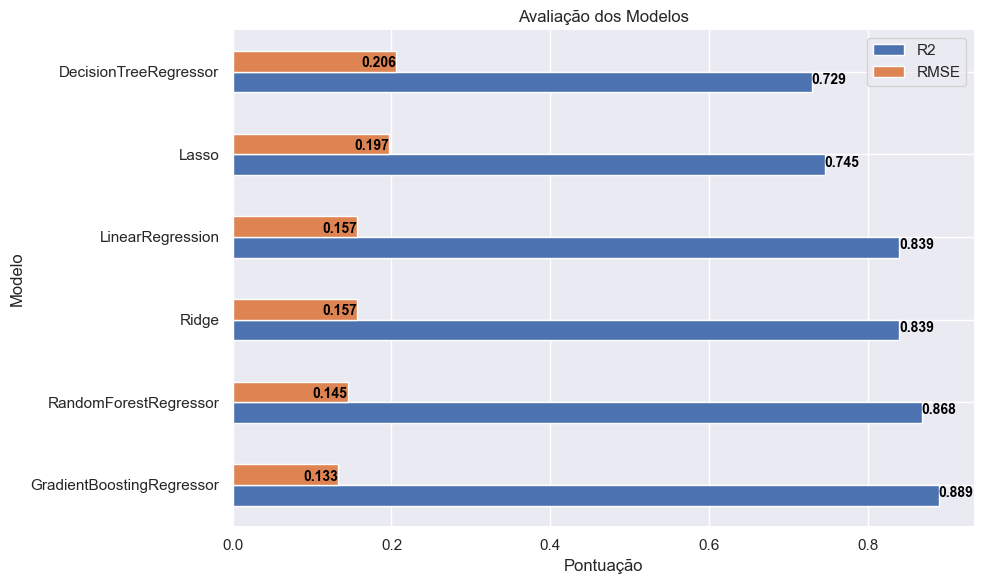

In [782]:
def plot_model_evaluation(results_df):
    results_df = results_df.sort_values(by='RMSE')  # Ordenar por RMSE em ordem crescente
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotar o gráfico de barras
    results_df.plot(x='Model', y=['R2', 'RMSE'], kind='barh', ax=ax)

    # Configurar o título e os rótulos dos eixos
    plt.title('Avaliação dos Modelos')
    plt.xlabel('Pontuação')
    plt.ylabel('Modelo')

    # Definir deslocamento vertical das pontuações
    r2_offset = -0.1  # Deslocamento para cima do R2
    rmse_offset = 0.1  # Deslocamento para baixo do RMSE

    # Adicionar as pontuações acima de cada barra
    for i, value in enumerate(results_df['R2']):
        ax.text(value, i + r2_offset, f'{value:.3f}', ha='left', va='center', color='black', fontweight='bold')

    for i, value in enumerate(results_df['RMSE']):
        ax.text(value, i + rmse_offset, f'{value:.3f}', ha='right', va='center', color='black', fontweight='bold')

    # Ajustar a fonte, tamanho e cor das pontuações
    for text in ax.texts:
        text.set_fontfamily('Arial')
        text.set_fontsize(10)
        text.set_color('black')

    # Ajustar o espaçamento entre as barras
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Exibir o gráfico
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    results_df = evaluate_models(models, X, y, cv)
    plot_model_evaluation(results_df)


Ao avaliarmos os modelos na versão simplificada da base de dados, observamos que o Gradient Boosting Regressor obteve um desempenho razoável, sem a necessidade de ajustes personalizados. Isso reforça sua popularidade como um modelo industrial amplamente utilizado em competições de Machine Learning. Por outro lado, o modelo de regressão linear teve um desempenho um pouco inferior. No entanto, é interessante notar que o modelo Lasso apresentou um desempenho insatisfatório, o que pode ser atribuído à falta de ajuste dos hiperparâmetros. 

Além disso, é interessante notar que o Ridge e LM deram a mesma coisa. A Regressão Linear é um caso especial do modelo Ridge, em que o valor de alpha é igual a 0, ou seja, nenhuma regularização é aplicada. Isso significa que os coeficientes do modelo de Regressão Linear não são penalizados e são estimados apenas com base nos dados de treinamento.

# Missing Values

Irei tratar agora do problema de dados faltantes. 

In [783]:
def missing_values_check(house_data_train):
    missing_value_total = house_data_train.isna().sum().sort_values(ascending = False)
    missing_valores_perc = missing_value_total/len(house_data_train)
    missing_valores_house = pd.concat([missing_valores_perc,missing_value_total], axis = 1, keys = ["%","Qtde"])
    print(missing_valores_house[missing_valores_house["Qtde"] > 0]) 

missing_values_check(house_data_train)

                     %  Qtde
PoolQC        0.995205  1453
MiscFeature   0.963014  1406
Alley         0.937671  1369
Fence         0.807534  1179
MasVnrType    0.597260   872
FireplaceQu   0.472603   690
LotFrontage   0.177397   259
GarageYrBlt   0.055479    81
GarageCond    0.055479    81
GarageType    0.055479    81
GarageFinish  0.055479    81
GarageQual    0.055479    81
BsmtFinType2  0.026027    38
BsmtExposure  0.026027    38
BsmtQual      0.025342    37
BsmtCond      0.025342    37
BsmtFinType1  0.025342    37
MasVnrArea    0.005479     8
Electrical    0.000685     1


Vimos na análise exploratória do primeiro notbook, que os habitantes da cidade não curtem muitas piscinas. Vamos atribuir NA para elas. Também para MiscFeature, que é uma categoria que possui itens especiais, como quadra de tênis. Então é esperado que muitas casas não possuam mesmo. Para Fence também, casas sem cerca. Para a variável "Alley" (acesso à propriedade), é provável que a falta de valores seja devido a casas que não possuem acessos diferenciados. Nesses casos, o acesso à propriedade deve ser pela rua principal, que passa em frente à casa, por exemplo. Portanto, podemos preencher os dados faltantes com o valor "NA".

Quanto à variável "FireplaceQu" (qualidade das lareiras), a falta de dados provavelmente indica que o número de lareiras é zero. Para LotFrontage não sabemos se o problema é em função da falta de dados ou inexistência da possibilidade de termos uma medida de frente da propriedade devido a suas características. Como o número de dados faltantes é alto, vamos ignorar esse feature, excluindo-o.

Podemos notar que GarageYrBlt, GarageType, GarageFinish, GarageQual, GarageCond tem a mesma quantidade de dados faltantes, o que indica que o problema deve ser na questão da falta de garagens. Podemos chegar isso com área de garagem igual a 0. 


In [784]:
len(house_data_train[house_data_train['GarageType'].isna()]['GarageArea'] == 0)


81

Ok, o valor é 81, que é a mesma quantidade de dados faltantes para essas variáveis. 

In [785]:
feature_list = ['PoolQC', 'MiscFeature', 'Fence', 'Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for feature in feature_list:
    house_data_train[feature] = house_data_train[feature].fillna('NA')

house_data_train.drop(columns=['GarageYrBlt', 'LotFrontage'], inplace=True)

Os dados faltantes nas colunas "BsmtFinType2", "BsmtExposure", "BsmtFinType1", "BsmtCond" e "BsmtQual" parecem indicar a inexistência de porão. No entanto, observe que as duas últimas colunas possuem uma observação adicional sem dados.

Para verificar nossa hipótese de que os dados faltantes nessas colunas estão relacionados à ausência de porão, podemos verificar a área total do porão disponível. Vamos fazer isso:

In [786]:
# Verificar a área total de porão disponível
len(house_data_train[house_data_train['BsmtFinType1'].isna()]['TotalBsmtSF'] == 0)

37

In [787]:
# imputando NA para essas observações
feature_list = ['BsmtFinType1', 'BsmtCond', 'BsmtQual']

for feature in feature_list:
    house_data_train[feature] = house_data_train[feature].fillna('NA')

Como restará um valor valtante para BsmtFinType2 e BsmtExposure, a preenchemos com 'Unf' e 'No', que representam as categorias predominantes nessas features:

In [788]:
house_data_train['BsmtFinType2'] = house_data_train['BsmtFinType2'].fillna('Unf')
house_data_train['BsmtExposure'] = house_data_train['BsmtExposure'].fillna('No')

Para as 8 observações sem dados de MasVnrArea e MasVnrType, iremos preencher o tipo mais comum, que é "None", para a coluna MasVnrType. Além disso, iremos atribuir o valor 0 para a coluna MasVnrArea, já que a maioria das observações possui essa área como 0.

Quanto à observação com dado faltante para Electrical, iremos preencher com a categoria predominante, que é "SBrkr".

Realizando essas imputações, podemos completar o código da seguinte forma:

In [789]:
house_data_train['MasVnrType'].fillna('None', inplace=True)
house_data_train['MasVnrArea'].fillna(0, inplace=True)
house_data_train['Electrical'].fillna('SBrkr', inplace=True)   # sistema elétrico mais comum na casa


In [790]:
missing_values_check(house_data_train)

Empty DataFrame
Columns: [%, Qtde]
Index: []


Indicando que não há mais dados faltantes em nosso dataset.

# Engenharia de Features e Modelagem (Parte 2)

__Criação de Novas Features__

Nessa etapa, exploramos a criação de novas features com base nas existentes. Por exemplo, consideramos a área total acima do solo (total living area), a área do porão e a área da garagem. A partir dessas informações, criamos uma nova feature chamada "total_area", que representa a soma dessas três áreas.


In [791]:
house_data_train['HouseArea'] = house_data_train["GrLivArea"]  + house_data_train["TotalBsmtSF"] + house_data_train["GarageArea"] 
house_data_train['HouseArea'].corr(house_data_train["SalePrice"])

0.8075184760515012

Na etapa de criação de features, também decidimos explorar a área de varandas. Embora as variáveis individuais (OpenPorchSF, EnclosedPorch, 3SsnPorch e ScreenPorch) não apresentassem um poder preditivo significativo ou correlações fortes com outras variáveis, decidimos combinar essas informações em uma nova feature.

Assim, criamos uma nova variável chamada "TotalPorchArea" que representa a soma das áreas das varandas. Essa nova feature nos permite capturar a informação geral sobre a área total de varandas, em vez de analisar as variáveis individuais separadamente.

Ao combinar as variáveis de área de varandas em uma única feature, podemos obter uma representação mais abrangente da área de varandas da casa, o que pode ser relevante para a predição do preço de venda.

In [792]:
house_data_train['PorchArea'] =house_data_train['OpenPorchSF'] + house_data_train['EnclosedPorch'] + house_data_train['3SsnPorch'] + house_data_train['ScreenPorch']


Na análise da quantidade de banheiros, observamos que a variável FullBath apresenta uma correlação interessante com o preço de venda, conforme visualizado no mapa de calor da Análise Exploratória de Dados (AED), com um valor de 0.56. No entanto, existem outras três features relacionadas a banheiros e lavabos que possuem correlações mais baixas (HalfBath, BsmtFullBath, BsmtHalfBath).

In [793]:
house_data_train['TotalBath'] = house_data_train['FullBath'] + 0.5 * house_data_train['HalfBath'] + house_data_train['BsmtFullBath'] + 0.5 *house_data_train['BsmtHalfBath']
house_data_train['TotalBath'].corr(house_data_train['SalePrice'])

0.6317310679319874

__Conversão de features númericas para categóricas nominais__

É importante ressaltar que a variável MSSubClass, apesar de ser representada por valores numéricos, possui uma natureza categórica nominal. Portanto, realizamos a conversão dessa variável para uma categoria nominal, a fim de evitar qualquer interpretação errônea de uma ordem ou relação numérica.

Da mesma forma, a variável que representa o mês de venda não possui uma ordem específica, sendo apenas um indicativo do mês em que a venda ocorreu. Portanto, também realizamos a conversão dessa variável para uma categoria categórica nominal, para evitar qualquer viés relacionado a uma suposta ordem temporal.

Seguindo a mesma lógica, realizamos a conversão da variável que representa o ano de venda para uma categoria categórica nominal. Embora a variável seja numérica, o ano de venda não apresenta uma relação de ordem, uma vez que estamos tratando de diferentes anos e não há uma escala temporal que indique uma ordem crescente ou decrescente.

Dessa forma, ao converter essas variáveis para categorias categóricas nominais, estamos garantindo uma interpretação correta e evitando possíveis vieses decorrentes de uma interpretação incorreta da ordem ou relação numérica.

In [794]:
features_list = ['MSSubClass', 'MoSold', 'YrSold']

# Convertendo as variáveis para categoria categórica nominal
for feature in features_list:
    house_data_train[feature] = house_data_train[feature].astype('category', copy=False)

__Agrupamento de categorias em features categóricas nominais__


In [795]:
feature_list = ['Condition1', 'GarageType', 'SaleType', 'GarageQual', 'GarageCond']
map_ = [['Slab', 'Stone', 'Wood'],
        ['Basment', 'CarPort', '2Types'],
        ['ConLD', 'ConLw', 'ConLI', 'CWD', 'Oth', 'Con'],
        ['Ex', 'Po'],
        ['Ex', 'Po']]

len(map_) == len(feature_list)
for feature, mapping in zip(feature_list, map_):
    house_data_train[feature] = house_data_train[feature].map(dict(zip(mapping, range(len(mapping)))))

__Seleção de Features__

Durante a análise exploratória dos dados, observamos que algumas características possuem uma categoria ou valor que está presente na grande maioria das amostras, o que indica que essas características podem não ter muito poder de diferenciação de preço e podem gerar apenas ruído nos nossos modelos. Portanto, decidimos eliminar essas características do conjunto de dados.

In [796]:
drop_list = ['PoolArea', 'PoolQC', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'Street']
house_data_train.drop(drop_list, axis=1, inplace=True)          ## dropando nas colunas

Criamos algumas features novas, então algumas acabam ficando redundantes. 

In [797]:
drop_list = [
    'TotalBsmtSF', 'GarageArea', 
    'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'YearBuilt', 'YearRemodAdd'
    ]
house_data_train.drop(drop_list, axis=1, inplace=True)    ## eliminando 

Ainda possuímos algumas variáveis de área causando multicolinearidade perfeita, então vamos eliminar algumas delas

In [798]:
drop_list = [
    'BsmtFinSF2', 'LowQualFinSF'          # área do porão do segundo tipo e Área com acabamento de baixa qualidade 
    ]
house_data_train.drop(drop_list, axis=1, inplace=True)

__Outliers__
Um de nossos principais preditores de preço é a área útil da casa. Como observamos no AED, possuímos algumas observações com área acima do solo superior a 4000 pés quadrados que destoam do padrão observado nas demais casas. Assim, optamos por eliminar essas observações:

In [799]:
house_data_train = house_data_train[house_data_train['GrLivArea'] < 4000]

__Preparação dos Dados para Modelagem__

Para as variáveis categóricas, utilizaremos a técnica de one-hot encoding. Posteriormente, removeremos as variáveis fictícias (dummies) que possuírem menos de 10 observações, caso existam.

Em relação às variáveis numéricas, iremos verificar a medida de assimetria (skewness) de cada uma. Se a assimetria for maior que 1, indicando uma assimetria considerável à direita, aplicaremos uma transformação logarítmica para reduzi-la. Embora alguns algoritmos não sejam afetados por essa transformação, como estamos utilizando vários algoritmos e temos a flexibilidade de incluir outros facilmente, optamos por adotar essa abordagem.

In [800]:
# Remover colunas com valores ausentes
house_data_train = house_data_train.dropna(axis=1)

# Crianndo dummies
house_data_train= pd.get_dummies(house_data_train)

X = house_data_train.drop(columns = ['Id', 'SalePrice'])
y = np.log(house_data_train['SalePrice'])

numercial_features = X.select_dtypes(exclude=['uint8']).columns.tolist()

X_num = X[numercial_features].copy()
X_cat = X.drop(numercial_features, axis=1)

# Tratamento assimetria:
for feature in numercial_features:
    if X_num[feature].skew() > 1:
        # print("before:", df[feature].skew())
        X_num[feature] = np.log(X_num[feature] + 1)
        # print("after:", df[feature].skew())

# Esparsidade:
s = X_cat.sum() < 10
X_cat.drop(columns=s[s].index.tolist(), inplace=True)

# Composição Final:
X = pd.concat([X_num, X_cat], axis=1)


__Reavaliação e Seleção de modelos__

Após nossa "engenharia de features", testamos novamente os modelos em suas configurações padrão, em validação cruzada (reportamos os scores sobre teste), e é interessante notar como conseguimos melhorar o resultado do modelo de Regressão Linear.

In [801]:
cv = KFold(n_splits = 5, shuffle=True, random_state=random_state)
results = evaluate_models(models, X, y, cv)

results

,Model,R2,RMSE
0,LinearRegression,0.895612,0.126999
1,Ridge,0.908585,0.118987
2,Lasso,0.737250,0.201979
3,DecisionTreeRegressor,0.737029,0.201619
4,RandomForestRegressor,0.883847,0.134396
5,GradientBoostingRegressor,0.903479,0.122576


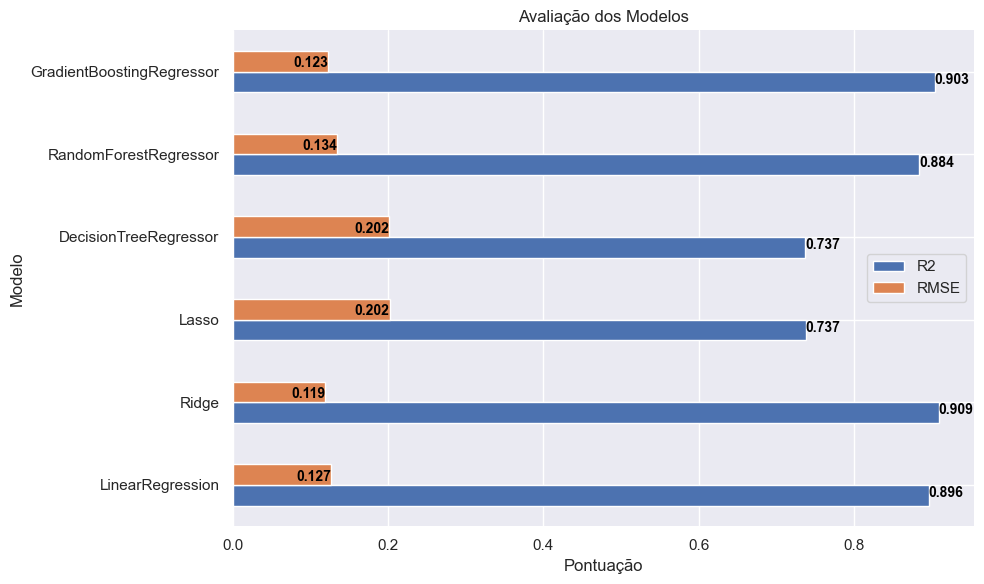

In [804]:
def plot_model_evaluation(results):
    results = results.sort_values(by='RMSE',  ascending=True)  # Ordenar por RMSE em ordem crescente
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotar o gráfico de barras
    results_df.plot(x='Model', y=['R2', 'RMSE'], kind='barh', ax=ax)

    # Configurar o título e os rótulos dos eixos
    plt.title('Avaliação dos Modelos')
    plt.xlabel('Pontuação')
    plt.ylabel('Modelo')

    # Definir deslocamento vertical das pontuações
    r2_offset = -0.1  # Deslocamento para cima do R2
    rmse_offset = 0.1  # Deslocamento para baixo do RMSE

    # Adicionar as pontuações acima de cada barra
    for i, value in enumerate(results_df['R2']):
        ax.text(value, i + r2_offset, f'{value:.3f}', ha='left', va='center', color='black', fontweight='bold')

    for i, value in enumerate(results_df['RMSE']):
        ax.text(value, i + rmse_offset, f'{value:.3f}', ha='right', va='center', color='black', fontweight='bold')

    # Ajustar a fonte, tamanho e cor das pontuações
    for text in ax.texts:
        text.set_fontfamily('Arial')
        text.set_fontsize(10)
        text.set_color('black')

    # Ajustar o espaçamento entre as barras
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Exibir o gráfico
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    results_df = evaluate_models(models, X, y, cv)
    plot_model_evaluation(results_df)

E interessante notar que conseguimos resultados, em validação cruzada, muito próximos para os três modelos calibrados, e melhoramos consideravelmente o desempenho do LM.

No entanto, é possível melhorar o desempenho de todos os modelos, incluindo a regressão linear, através da seleção adequada de seus hiperparâmetros. Podemos avaliar o quão bem podemos aprimorá-los utilizando a validação cruzada. Para essa tarefa, podemos utilizar as funções GridSearchCV e RandomizedSearchCV do pacote sklearn, que realizam uma busca exaustiva ou aleatória, respectivamente, pelos melhores hiperparâmetros com base em uma lista pré-definida. O objetivo é maximizar alguma métrica, como o erro médio quadrático negativo (negative mean squared error), no nosso caso. Dessa forma, podemos avaliar diferentes combinações de hiperparâmetros para cada modelo e determinar aquela que apresenta o melhor desempenho.

In [807]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

lasso_parameters = {'alpha': np.linspace(0.1, 1.0, num=(10 ** 2)) ** 6}
ridge_parameters = {'alpha': np.linspace(1, 100, num=100)}
gbr_parameters = {
    "loss": ['ls', 'lad', 'huber', 'quantile'],
    "learning_rate": [0.01, 0.02, 0.025, 0.033, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2],
    "min_samples_split": [0.05, 0.075, 0.1, 0.12, 0.15, 0.2, 0.25, 0.5, 1, 2, 5],
    "min_samples_leaf": [0.1, 0.25, 0.5, 1, 2, 5, 10],
    "max_depth": [3, 5, 8],
    "max_features": ["auto", "log2","sqrt"],
    "criterion": ["friedman_mse", "mse"],
    "subsample": [0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators": [250, 500, 1000]
    }

gs_lasso = GridSearchCV(Lasso(), lasso_parameters, cv=cv, scoring='neg_mean_squared_error')
gs_lasso.fit(X, y)
print(gs_lasso.best_estimator_)

gs_ridge = GridSearchCV(Ridge(), ridge_parameters, cv=cv, scoring='neg_mean_squared_error')
gs_ridge.fit(X, y)
print(gs_ridge.best_estimator_)

# gs_gbr = GridSearchCV(gbr, parameters, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
gs_gbr = RandomizedSearchCV(GradientBoostingRegressor(random_state=random_state), gbr_parameters, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=500)
gs_gbr.fit(X, y)
print(gs_gbr.best_estimator_)

Lasso(alpha=0.00033576225769250983)
Ridge(alpha=10.0)
GradientBoostingRegressor(learning_rate=0.033, loss='huber', max_depth=5,
                          max_features='sqrt', min_samples_leaf=2,
                          min_samples_split=0.075, n_estimators=500,
                          random_state=0, subsample=0.65)


Utilizando o melhor modelo para cada tipo de regressor, realizamos nova validação cruzada:

In [809]:
models = [
    LinearRegression(),
    gs_ridge.best_estimator_,
    gs_lasso.best_estimator_,
    gs_gbr.best_estimator_
    ]

results = evaluate_models(models, X, y, cv)

results

,Model,R2,RMSE
0,LinearRegression,0.895612,0.126999
1,Ridge,0.912733,0.116526
2,Lasso,0.915715,0.114486
3,GradientBoostingRegressor,0.916711,0.113835


In [ ]:
É importante ressaltar que obtivemos resultados muito semelhantes em termos de validação cruzada para os três modelos ajustados, e houve uma melhoria significativa no desempenho do modelo Lasso.